<a href="https://colab.research.google.com/github/siddhartha201/CSC-752-Project/blob/main/Late%20Fusion%20with%20CLIP_VGG16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization

import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/siddhartha201/CSC-752-Project/

fatal: destination path 'CSC-752-Project' already exists and is not an empty directory.


In [4]:
file_path = "/content/CSC-752-Project/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_path)

### Build NLP model


In [5]:
# Filter out rows where 'Classification' is not 'benign' or 'malignant'
filtered_text_data = text_data[(text_data['Classification'] == 'benign') | (text_data['Classification'] == 'malignant')].copy()

# Combine the relevant textual columns into a single text field per case
text_columns = [col for col in filtered_text_data.columns if col not in ['Image_filename', 'Classification', 'Mask_tumor_filename', 'Mask_other_filename', 'Pixel_size', 'Verification', 'BIRADS']]

# Now, modify the 'combined_text' column explicitly on the copy of the filtered DataFrame
filtered_text_data.loc[:, 'combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [6]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

text_inputs = processor(text=filtered_text_data["combined_text"].tolist(), padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
text_embeddings = model.get_text_features(**text_inputs)

In [8]:
def get_image_embedding(image_path, processor, model):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    # Generate embedding
    with torch.no_grad():  # Ensure no gradients are calculated
        image_embedding = model.get_image_features(**inputs)

    return image_embedding

In [9]:
# add label
labels = filtered_text_data['Classification'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Converts labels to numerical format

In [10]:
# Convert it to a NumPy array
X = text_embeddings.detach().numpy()

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

In [12]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),                 # Dropout layer for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),         # BatchNormalization layer for normalization
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.3, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6127 - loss: 0.6374 - val_accuracy: 0.9344 - val_loss: 0.5093
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8447 - loss: 0.3326 - val_accuracy: 0.9508 - val_loss: 0.3896
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9549 - loss: 0.1835 - val_accuracy: 0.9180 - val_loss: 0.3202
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9636 - loss: 0.1319 - val_accuracy: 0.9180 - val_loss: 0.2715
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9729 - loss: 0.0813 - val_accuracy: 0.9508 - val_loss: 0.2031
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9800 - loss: 0.0773 - val_accuracy: 0.9836 - val_loss: 0.1523
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9922 - loss: 0.0684 - val_accuracy: 0.9836 - val_loss: 0.1225
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9753 - loss: 0.0529 - val_accuracy: 0.9836 - val_loss

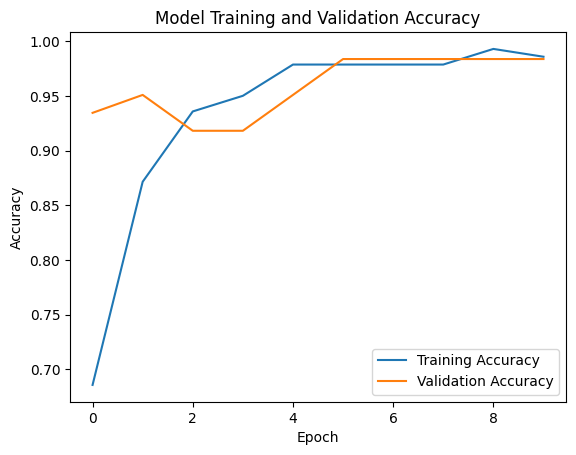

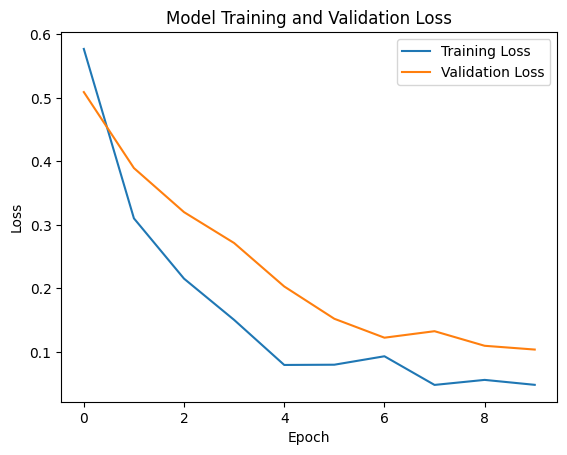

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
model.save('C:/Users/alan/Medical Image Project/CLIP_NLP.h5')

In [15]:
from tensorflow.keras.models import load_model
dir = 'C:/Users/alan/Medical Image Project'
nlp_model = load_model(dir +'/CLIP_NLP.h5')

In [16]:
text_predictions = nlp_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


### Build Image Model


In [18]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import os

base_model = VGG16(weights='imagenet', include_top=False)  # Load VGG16 without the classification layers
base_path = "/content/CSC-752-Project/BrEaST-Lesions_USG-images_and_masks"
def get_cnn_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)  # Preprocess the image
    features = base_model.predict(preprocessed_img)
    flattened_features = features.flatten()  # Flatten the features to a 1D array
    return flattened_features

cnn_embeddings =[]
for filename in filtered_text_data['Image_filename']:
    image_path = os.path.join(base_path, filename)
    embedding = get_cnn_features(image_path)
    cnn_embeddings.append(embedding)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [19]:
# Assuming cnn_embeddings is a numpy array of your embeddings and encoded_labels are your target labels
X_train, X_test, y_train, y_test = train_test_split(cnn_embeddings, encoded_labels, test_size=0.2, random_state=42)
# Convert X_train and y_train to NumPy arrays if they're not already
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)



In [20]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(25088,)),  # Adjust the layer sizes as needed
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,977,153 (49.50 MB)

 Trainable params: 12,977,153 (49.50 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train,
                    epochs=12,
                    batch_size=16,
                    validation_split=0.2)  # Using part of the training data for validation


Epoch 1/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.4712 - loss: 12.9423 - val_accuracy: 0.5122 - val_loss: 4.5863
Epoch 2/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.5860 - loss: 13.2226 - val_accuracy: 0.5366 - val_loss: 8.4116
Epoch 3/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.6633 - loss: 10.9282 - val_accuracy: 0.6585 - val_loss: 4.8490
Epoch 4/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.7702 - loss: 6.7202 - val_accuracy: 0.5854 - val_loss: 8.0309
Epoch 5/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7787 - loss: 4.4654 - val_accuracy: 0.6585 - val_loss: 10.3049
Epoch 6/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.7677 - loss: 5.5939 - val_accuracy: 0.6098 - val_loss: 6.2124
Epoch 7/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.7949 - loss: 4.0536 - val_accuracy: 0.6341 - val_loss: 14.2805
Epoch 8/12
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.8780 - loss: 4.7121 - val_accurac

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7232 - loss: 5.6554
Test Accuracy: 0.7254902124404907


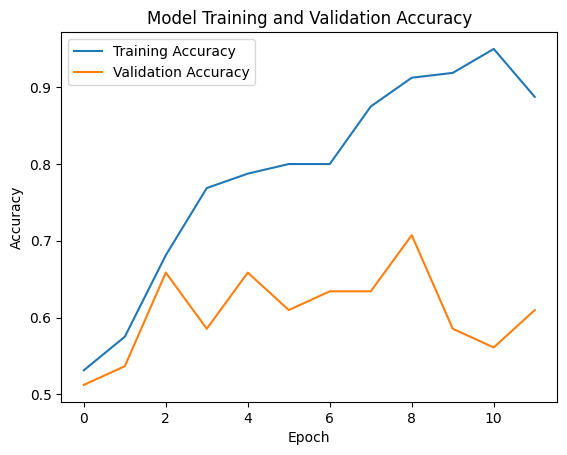

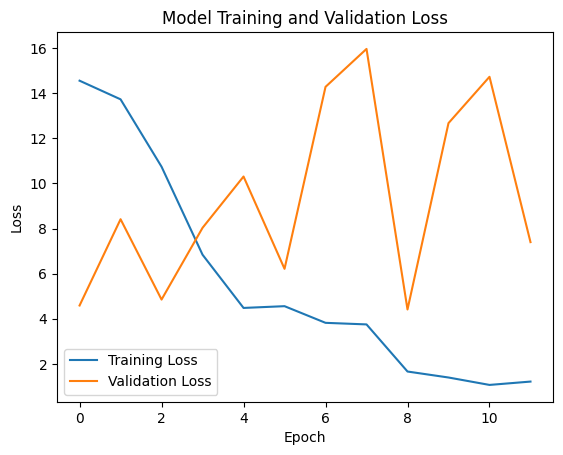

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
model.save('C:/Users/alan/Medical Image Project/Simple_CNN.h5')

In [25]:
dir = 'C:/Users/alan/Medical Image Project'
cnn_model = load_model(dir +'/Simple_CNN.h5')

In [26]:
image_predictions = cnn_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [27]:
# Ensure predictions are in the same scale/format, e.g., probabilities
# Example: weighted average favoring one set of predictions
weight_text = 0.6
weight_image = 0.4
final_predictions = (text_predictions * weight_text) + (image_predictions * weight_image)

In [28]:

# Assuming a threshold of 0.5 for binary classification
threshold = 0.5
predicted_labels = np.where(final_predictions > threshold, 1, 0)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)


Accuracy: 0.9803921568627451
Precision: 0.9411764705882353
Recall: 1.0
F1 Score: 0.9696969696969697
Confusion Matrix:
[[34  1]
 [ 0 16]]
